# **BRIN?**

**Block Range Index**


- PostgreSQL 9.5부터 등장
- 특정 열이 테이블 내의 물리적 위치와 자연적인 상관관계가 있는 매우 큰 테이블을 처리하기 위해 설계
- 블록 범위는 테이블에서 물리적으로 인접한 페이지 그룹이며, 각 블록 범위에 대해 일부 요약 정보가 인덱스에 저장
- 예를 들어, 상점의 판매 주문을 저장하는 테이블에는 각 주문이 배치된 날짜 열이 있을 수 있으며, 대부분의 경우 이전 주문에 대한 항목도 표에 앞부분에 표시
- ZIP 코드 열을 저장하는 표는 자연스럽게 함께 그룹화된 도시의 모든 코드를 가질 수 있음
- BRIN 인덱스는 일반 비트맵 인덱스 스캔을 통해 쿼리를 충족할 수 있으며 인덱스에 저장된 요약 정보가 쿼리 조건과 일치하는 경우 각 범위 내 모든 페이지의 모든 튜플을 반환
- 쿼리 실행기는 이러한 튜플을 다시 확인하고 쿼리 조건과 일치하지 않는 튜플을 버리는 역할-> 조건에 부합하지 않는 인덱스는 손실
- BRIN 인덱스는 매우 작기 때문에 인덱스를 스캔하면 순차 스캔에 비해 오버헤드가 거의 추가되지 않지만 일치하는 튜플을 포함하지 않는 것으로 알려진 테이블의 큰 부분을 스캔하는 것을 피할 수 있음
- BRIN 인덱스가 저장할 특정 데이터와 인덱스가 충족할 수 있는 특정 쿼리는 인덱스의 각 열에 대해 선택된 연산자 클래스에 따라 다름.   -> 선형 정렬 순서를 갖는 데이터 유형 : 각 블록 범위 내에서 최소값과 최대값을 저장하는 연산자 클래스를 가질 수 있음  -> 기하학적 유형은 블록 범위의 모든 객체에 대한 경계 상자를 저장할 수 있음
- 블록 범위의 크기는 인덱스 생성 시 pages_per_range 저장 매개변수에 의해 결정
- 인덱스 항목의 수는 페이지의 관계 크기를 pages_per_range에 대해 선택한 값으로 나눈 값과 같음. 즉, 숫자가 작을수록 인덱스는 더 커지지만(더 많은 인덱스 항목을 저장해야 하기 때문에), 동시에 저장된 요약 데이터가 더 정확할 수 있고 인덱스 스캔 중에 더 많은 데이터 블록을 건너뛸 수 있음


**인덱스 유지 관리**


- 생성 시 기존의 모든 인덱스 페이지가 스캔되고 마지막에 불완전 범위를 포함하여 각 범위에 대해 요약 인덱스 튜플이 생성
- 새 페이지가 데이터로 채워지면 이미 요약된 페이지 범위로 인해 요약 정보가 새 튜플의 데이터로 업데이트됨
- 마지막으로 요약된 범위에 포함되지 않는 새 페이지가 생성될 때 해당 범위는 자동으로 요약 튜플을 얻지 않음
  -> 이러한 튜플은 나중에 요약 실행이 호출되어 초기 요약을 만들 때까지 요약되지 않은 상태로 유지
- 이 프로세스는 brin_summarize_new_values(regclass) 함수를 사용하여 수동으로 호출하거나 VACUM이 테이블을 처리할 때 자동으로 호출할 수 있음


**내장된 연산자 Class**

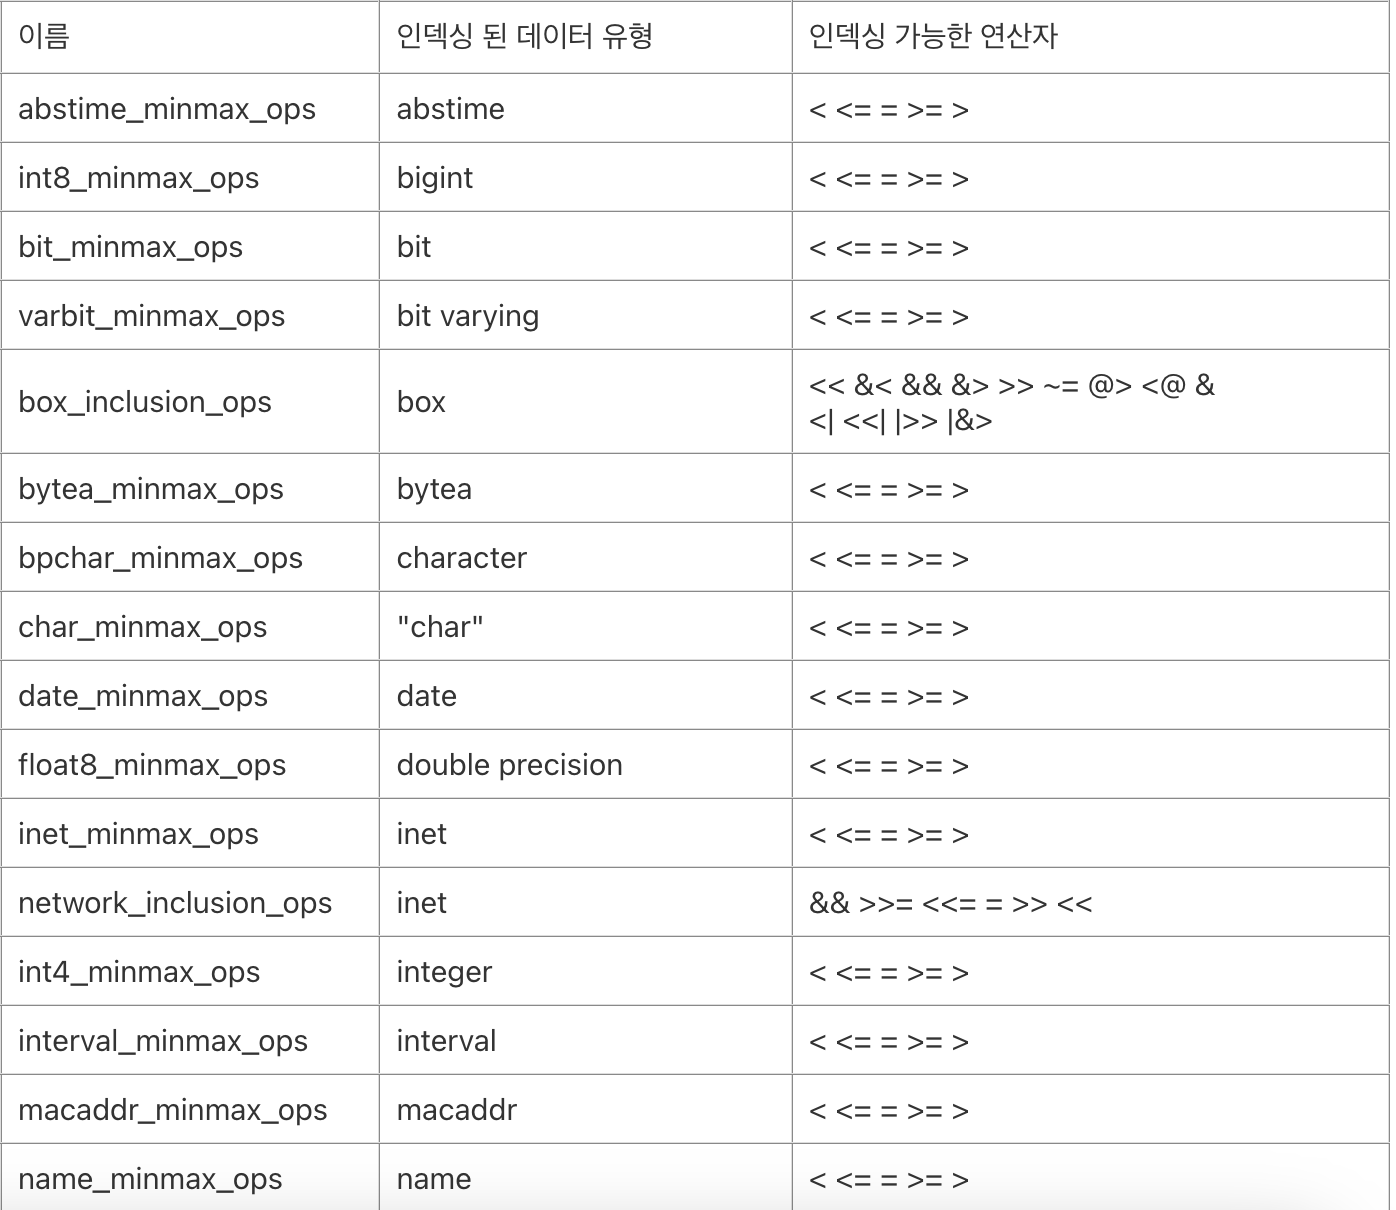
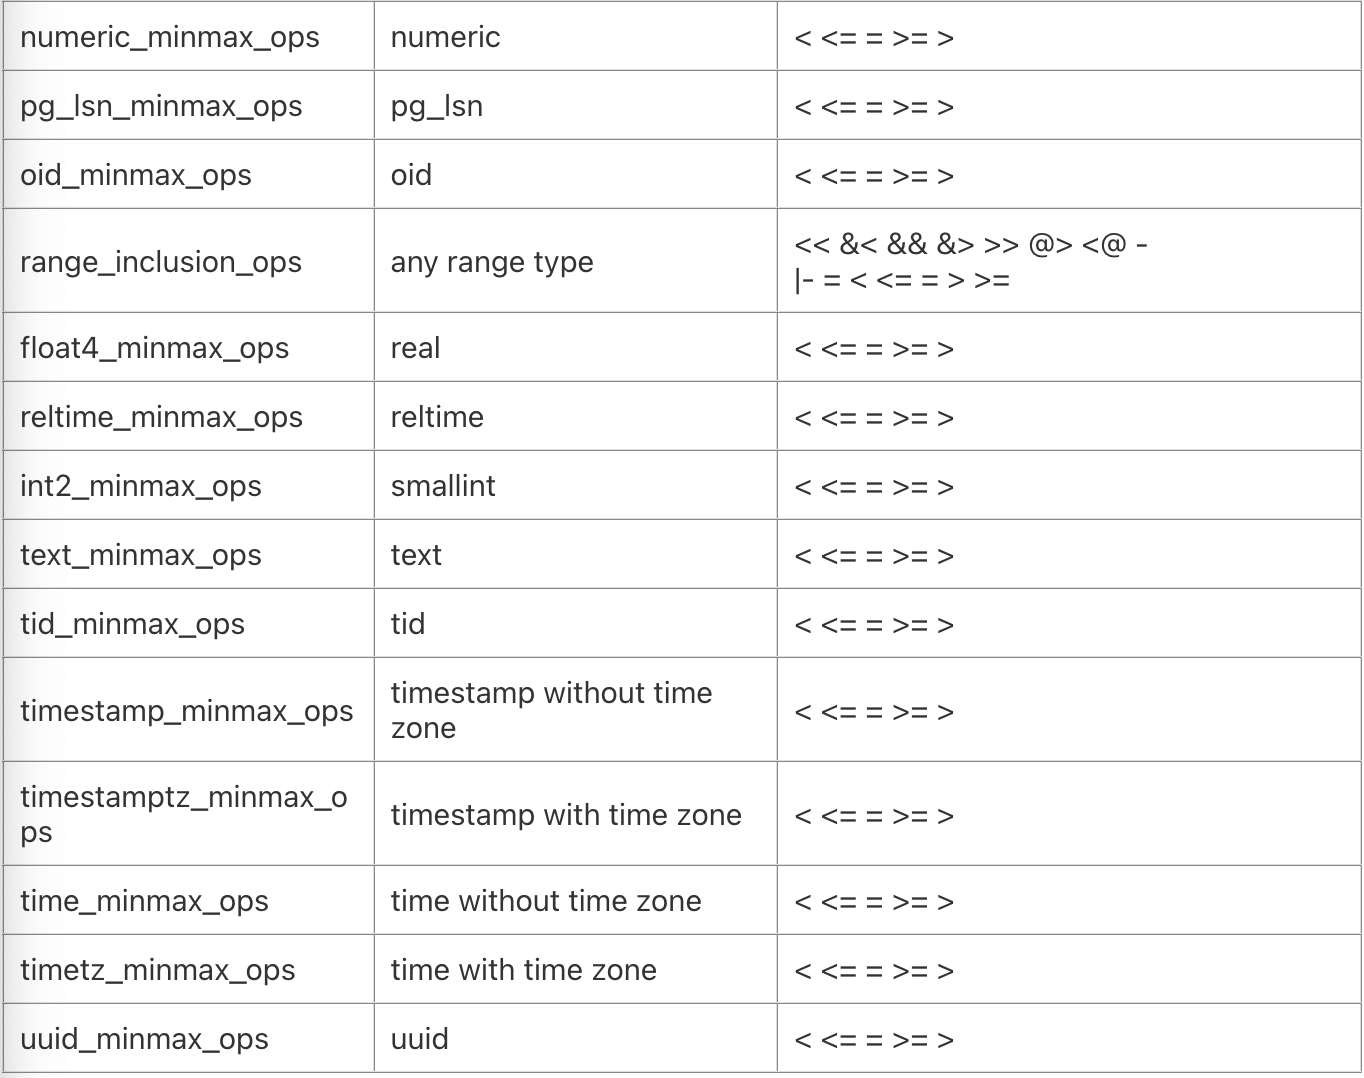

**확장성**

- BRIN 인터페이스는 높은 수준의 추상화를 가지고 있어 접근 방법 구현자가 접근 중인 데이터 유형의 의미만 구현하면 됨(BRIN 계층 자체는 동시성, 로깅, 인덱스 구조 검색을 담당)

- BRIN 액세스 메서드가 작동하려면 인덱스에 저장된 요약 값의 동작과 검색 키와 상호 작용하는 방식을 정의하는 몇 가지 사용자 정의 메서드를 구현하기만 하면 됨.
  - BRIN은 확장성과 일반성, 코드 재사용 및 깨끗한 인터페이스를 결합

**BRIN이 무조건 제공하는 4가지 연산자 클래스**

1. BrinOpcInfo *opcInfo(Oid type_oid)

 - 인덱싱된 컬럼의 요약 데이터에 대한 내부 정보를 반환. 리턴값은 이 정의가 있는 palloc'd BrinOpcInfo를 가리켜야 함

```
typedef struct BrinOpcInfo
{  
     /* Number of columns stored in an index column of this opclass */     uint16      oi_nstored;     

     /* Opaque pointer for the opclass' private use */     void       *oi_opaque;     

     /* Type cache entries of the stored columns */     
     TypeCacheEntry *oi_typcache[FLEXIBLE_ARRAY_MEMBER];
     } BrinOpcInfo;
```

 - BrinOpcInfo.oi_opaque는 인덱스 검색 중에 지원 프로시저 간에 정보를 전달하기 위해 연산자 클래스 루틴에서 사용할 수 있음

2. bool consistent(BrinDesc *bdesc, BrinValues *column, ScanKey key)

 - ScanKey가 지정된 범위의 인덱스 값과의 일치 여부를 반환
 - 이 때 사용할 특성 번호가 scan key의 일부로 반환

3. bool addValue(BrinDesc *bdesc, BrinValues *column, Datum newval, bool isnull)

 - 지정된 인덱스 튜플과 인덱스 값에 대해 새 값을 추가로 나타낼 수 있도록 튜플의 표시된 특성을 변환
 - 튜플의 수정 작업이 이뤄질 경우 true를, 그렇지 않을 경우에는 false를 반환

4. bool unionTuples(BrinDesc  *bdesc, BrinValues *a, BrinValues *b)

 - 두 인덱스 튜플을 통합
 - 두 개의 인덱스 튜플이 지정되었을 경우 첫 번째 튜플에 표기된 속성을 두 튜플을 모두 나타내도록 수정
 - 두 번째 튜플은 변환되지 않음

- 핵심 분포에는 두 가지 타입(minmax와 inclusion)의 연산자 클래스가 존재하는데, 이 연산자 클래스 정의는 인코어 데이터 유형에 맞게 제공.
- 소스 코드를 작성할 필요 없이 동일한 정의를 사용하여 다른 데이터 유형에 대한 추가 연산자 클래스를 정의할 수 있음.
- 운영자 전략의 의미에 대한 가정은 지원 절차의 소스 코드에 포함되어 있음

- 위에 작성된 4가지 주요 지원 절차의 구현이 작성되어 있다면, 완전히 다른 의미론을 구현하는 연산자 클래스도 가능하지만, 주요 릴리즈 간의 하위 호환성은 보장되지 않음(이후 릴리즈에서는 추가 지원 절차가 필요할 수 있음)

- 전체 순서 집합을 구현하는 데이터 유형에 대한 연산자 클래스를 작성하려면 아래와 같은 연산자들과 함께 minimax 지원 절차를 사용할 수 있음. 단, 모든 연산자 클래스 멤버는 필수임


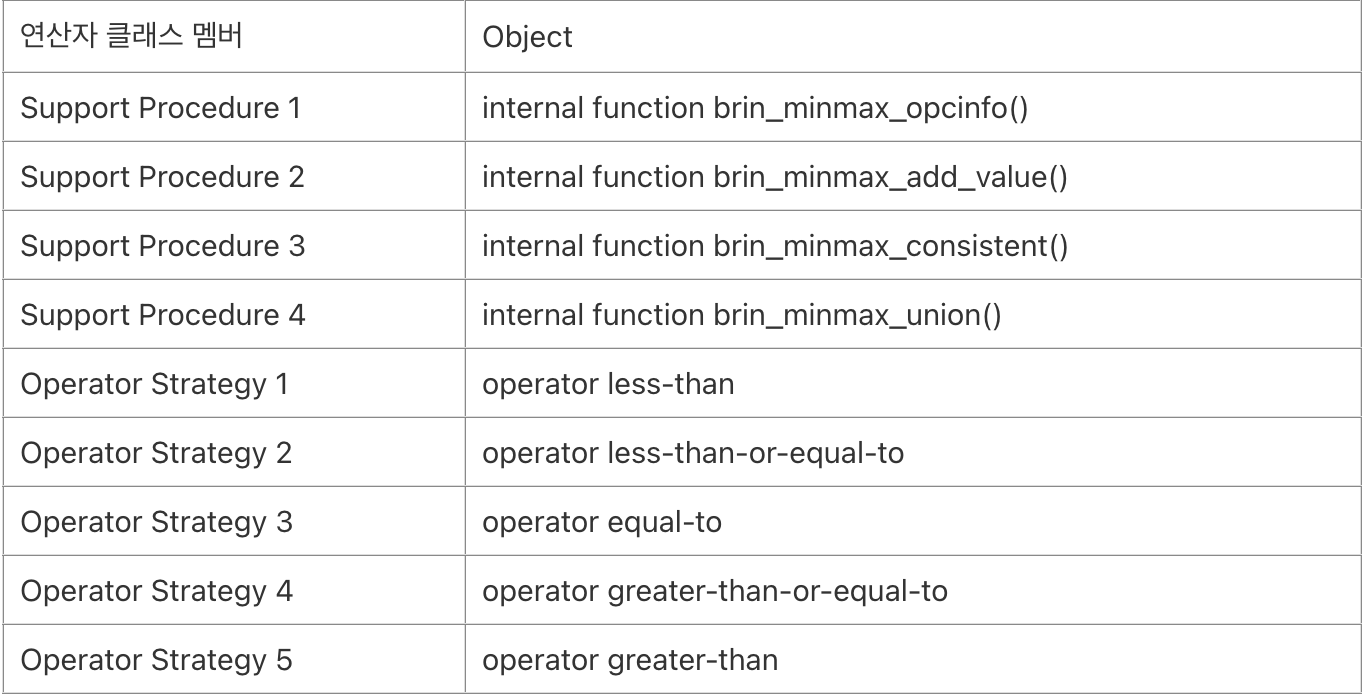

- 다른 타입의 값을 포함한 복잡한 데이터 타입에 대한 연산자 클래스를 작성하려면 아래 표와 같이 해당 연산자와 함께 포함 지원 절차를 사용할 수 있음.
- 어떠한 언어로든 작성할 수 있는 하나의 추가 함수만 필요하며, 추가 기능에 대해 다양한 함수를 정의할 수 있음(모든 연산자는 선택사항임. 표의 종속성으로 표현된 것처럼 일부 연산자는 다른 연산자를 요구함)

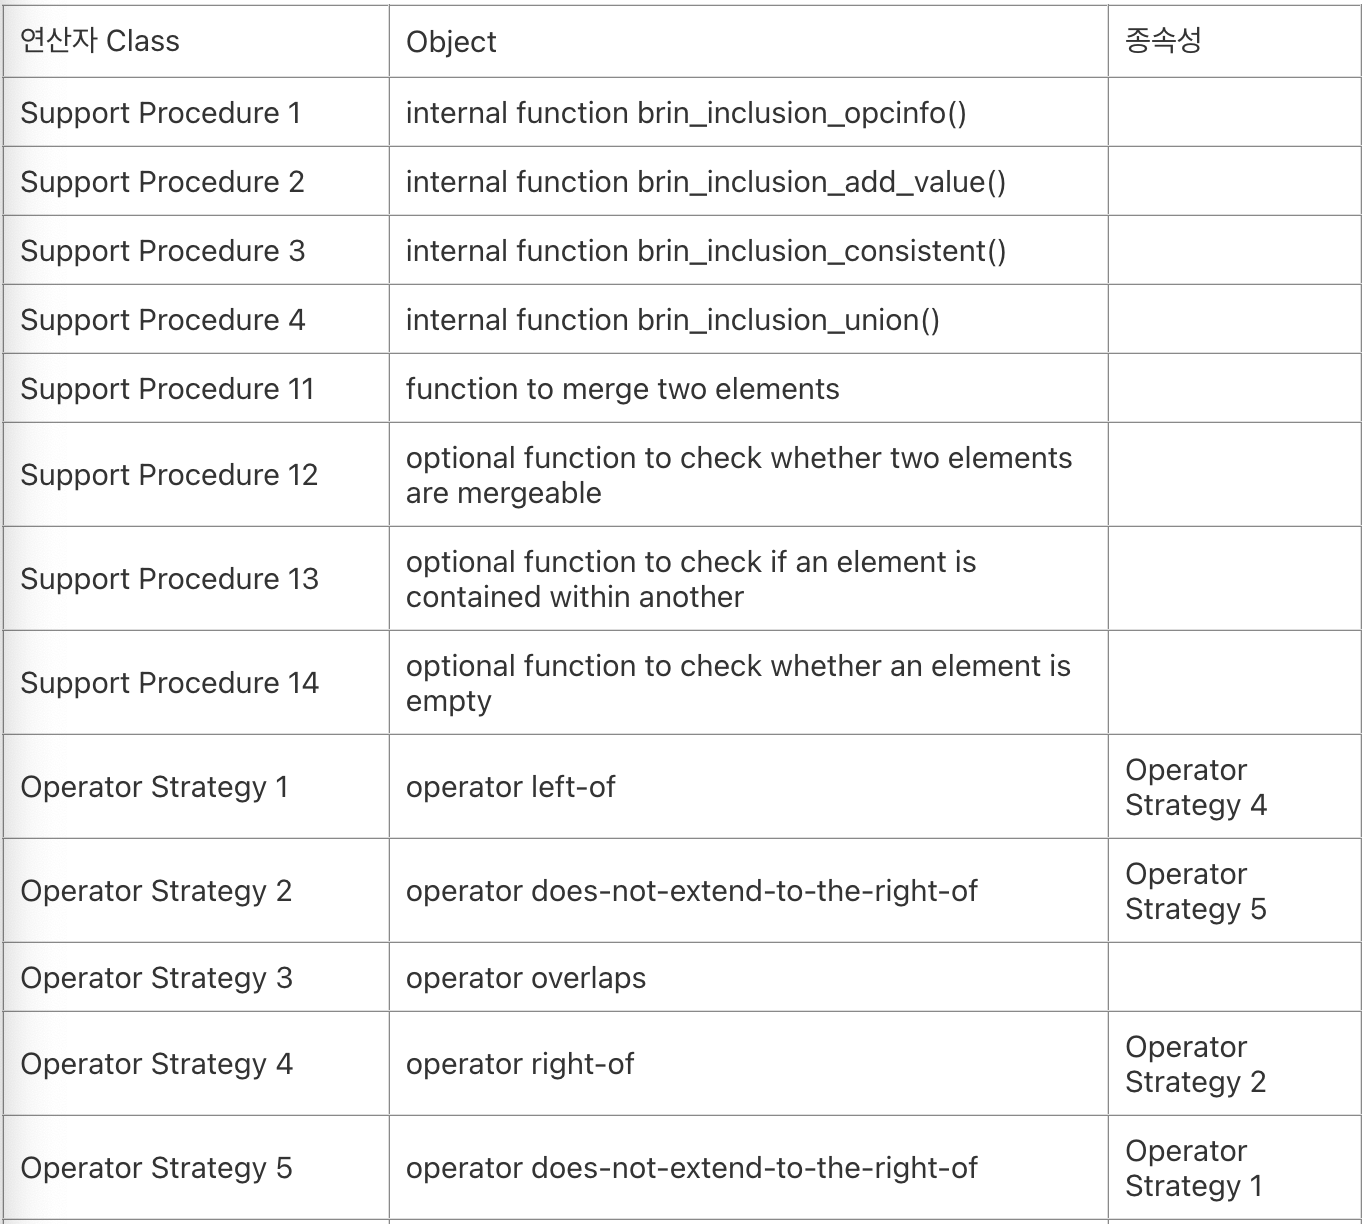
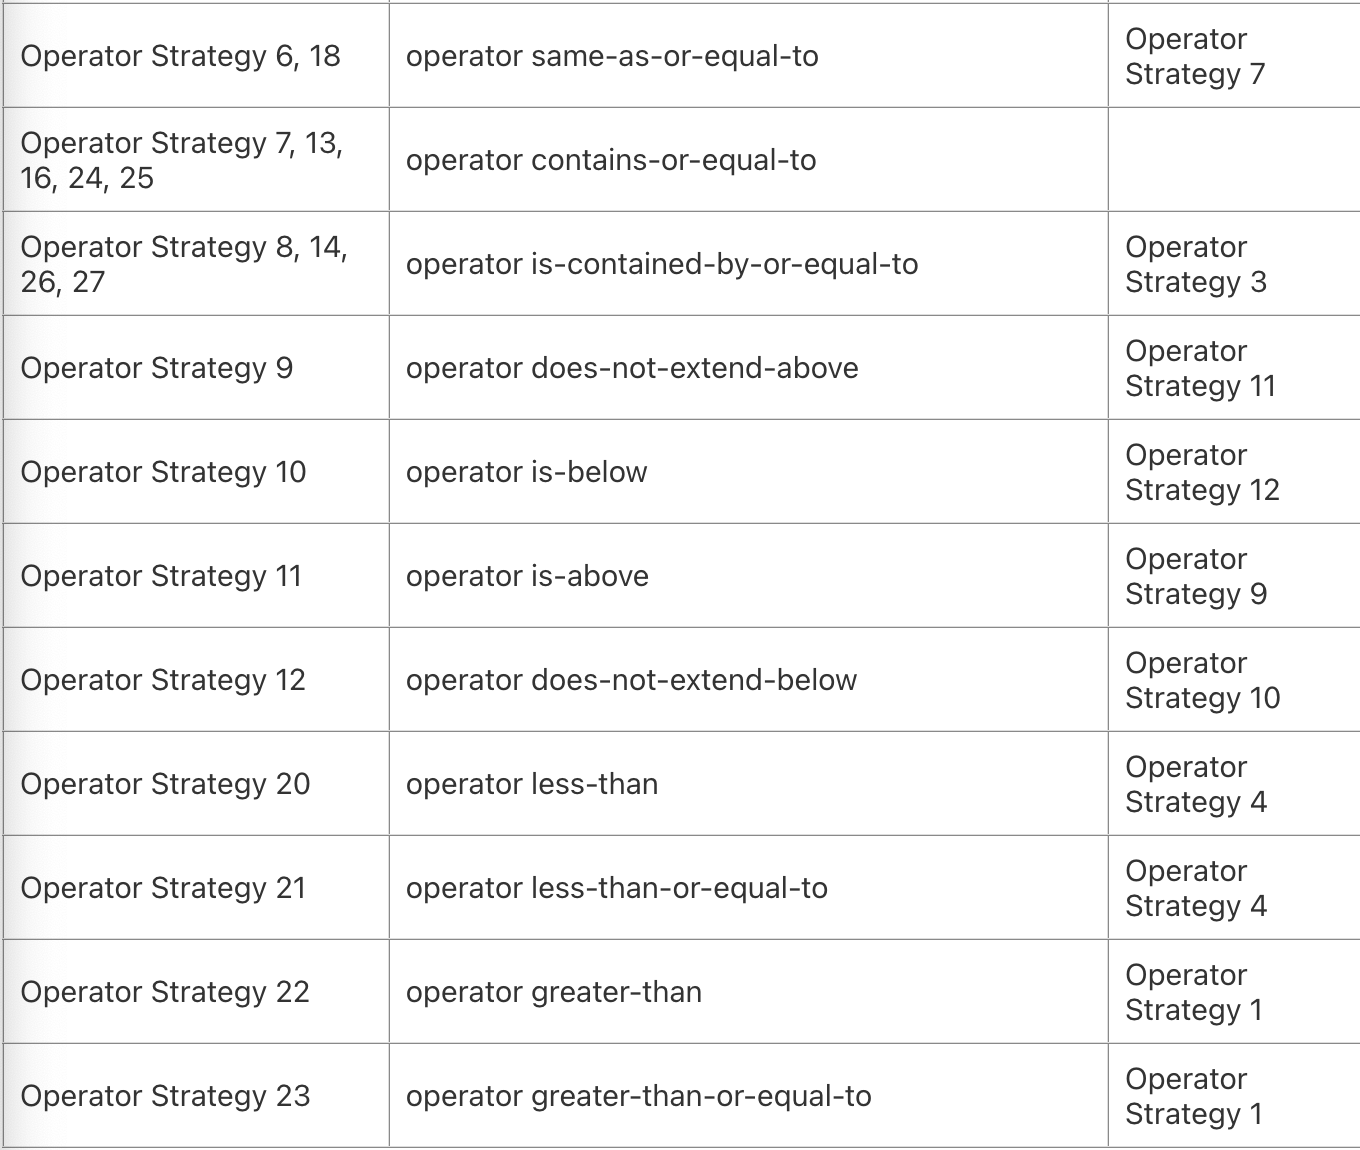

- Support procedure numbers 1-10 는 BRIN 내부 기능용으로 준비되어 있어서 SQL level 함수는 11부터 시작함. 11은 인덱스를 만들기 위해 필요한 주 기능.
- opclass와 동일한 타입을 가진 두 개의 인수를 허용하고 이들의 union value를 반환해야 함.
- STORAGE 파라미터를 통해 정의되었을 경우 inclution opclass는 다른 데이터 유형을 사용하여 union value를 저장할 수 있음. 이렇게 union된 함수는 값 반환 시 STORAGE 데이터 타입과 일치해야 함.

<br>

- Procedure numbers 12와 14는 만들어진 데이터다입에 대한 불규칙성을 지원하기 위해 제공
- Procedure number 12는 병합 불가능한 서로 다른 family의 네트워크 주소를 지원할 때 사용
- Procedure number 14는 빈 범위를 지원하는 데에 사용
- Procedure number 13은 선택적이지만 권장사양으로, union 함수를 통과하기 전에 확인할 수 있음
- BRIN framework는 union이 변경되지 않을 때 일부 연산을 단축할 수 있으므로 인덱싱 성능을 향상시킬 수 있음

<br>

- minmax와 inclusion opclass는 교차 데이터 유형 연산자를 지원하지만, 이 의존성이 복잡해질 수 있음.
- minmax opclass는 두 인수가 같은 같은 데이터 타입을 가진 전체 연산자 집합을 정의해야 함.
- inclusion opclass는 바로 위 장표와 같은 다른 연산자 전략이나 그들만의 같은 operator 전략에 의해 달라짐.
- 종속성 연산자는 스토리지 데이터 유형을 left-hand-side로 정의하고 지원되는 다른 데이터 유형을 지원되는 연산자의 right-hand-side 인수로 정의해야 함.
  - minmax의 예로는 float4_minmax_ops를, 포함 예로는 box_inclusion_ops를 참조


**btree와의 차이점**

- BRIN을 사용할 경우 특정 block 범위에 포함한 인덱스 대상 컬럼의 최대/최소값만을 저장함. btree는 모든 데이터를 인덱싱
- 이로 인해 BRIN의 인덱스는 btree에 비해 적으며(복잡한 트리 구조 작업 vs 블록 범위의 최대/최소값만 업데이트), insert/update가 간소화
- 인덱싱이 간단하고 빠름
- 그러나 BRIN이 특정 블록 범위만 다루다 보니, 검색 범위를 이탈할 경우 해당하는 블록 범위 전체를 검사
- lossy index이므로, 데이터의 hash 값을 저장하는 컬럼에 BRIN을 써도 데이터가 포함된 블록을 정확히 반환하지 못함
